# Working with SXS waveforms

It is straightforward to load SXS waveform data with the `sxs` package, and then perform fits to the ringdown using functions in `qnmfits`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sxs
import qnmfits

from qnmfits import utils

## Load and prepare waveform data

You can load an SXS `Simulation` object in the following way, which gives you easy access to the simulation metadata, but note that the strain data is slightly different to what we usually use so I will load that separately.

In [2]:
sim = sxs.load('SXS:BBH:0305', extrapolation='N2')

# We can easily extract simulation metadata:
Mf = sim.metadata.remnant_mass
chif = sim.metadata.remnant_dimensionless_spin
chif_mag = np.linalg.norm(chif)

# But note that sim.h is different to the older simulation data, so I will
# the older data separately to help with comparisons:
h = sxs.load('SXS:BBH:0305/Lev6/rhOverM', extrapolation_order=2)

/Users/eliot/Documents/Research/Ringdown/sxs-collaboration/qnmfits/.conda/lib/python3.10/site-packages/sxs/catalog/catalog.py:64: UserWarning: 

        You have called a function that uses the `Catalog` class,
        which, as of `sxs` version 2024.0.0, has been deprecated in
        favor of the `Simulations` interface.  See the documentation
        for more information.
        
  warn(deprecation_notice)


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


There is one caveat to be aware of, which is that `sxs.WaveformModes` are slightly different to `scri.WaveformModes`. We have written the functions in `qnmfits` to work with the latter, so we have to do a quick conversion to `scri.WaveformModes`:

In [3]:
type(h)

sxs.waveforms.waveform_modes.WaveformModes

In [4]:
h = utils.sxs_to_scri_WaveformModes(h)
type(h)

scri.waveform_modes.WaveformModes

Finally, we might want to redefine the zero time to make things easier. Here we use the time when the absolute value of the $(2,2)$ mode reaches its peak:

In [5]:
# We can extract individual spherical-harmonic modes like this:
h22 = h.data[:,h.index(2,2)]

# Shift the times
h.t -= h.t[np.argmax(np.abs(h22))]

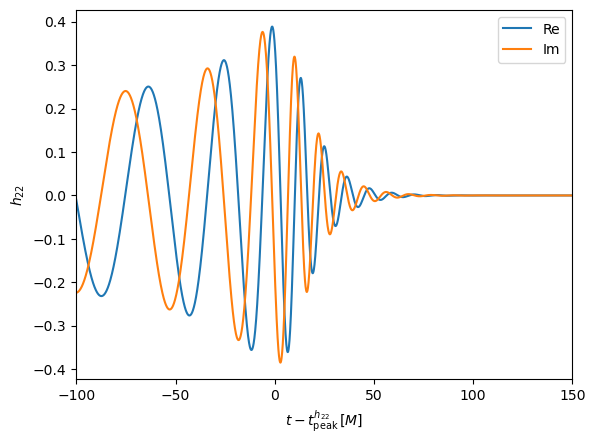

In [6]:
fig, ax = plt.subplots()

ax.plot(h.t, np.real(h22), label='Re')
ax.plot(h.t, np.imag(h22), label='Im')

ax.set_xlabel('$t - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$h_{22}$')

ax.legend()

ax.set_xlim(-100,150);

## Perform a single ringdown fit

The core function of the `qnmfits` package is `qnmfits.fit()`. Here we use it to perform a seven-overtone fit to the $h_{22}$ mode.

In [7]:
qnmfits.fit?

Signature:
qnmfits.fit(
    data,
    chif,
    Mf,
    qnms,
    spherical_modes=None,
    t0=0,
    T=100,
    t_ref=None,
    t0_method='geq',
)
Docstring:
Find the best-fit (as determined by a least-squares fit) complex QNM
amplitudes of a ringdown model, fitted to some data. The data is a
WaveformModes object, decomposed into spin-weighted spherical harmonics.
The fit can be performed to any subset of the spherical modes, and the
spherical-spheroidal mixing coefficients are used to correctly weight the
QNM amplitudes for each spherical mode.

The ringdown spectrum is fixed accoring to the provided chif and Mf values.

Parameters
----------
data : WaveformModes
    Waveform to use for fitting QNM amplitudes.

chif : float
    The magnitude of the dimensionless spin of the remnant black hole.
    Along with M, this determines the QNM frequencies.

Mf : float
    The mass of the remnant black hole. This is the factor which the QNM
    frequencies are divided through by, and so determ

In [8]:
# QNMs we want to fit for. The format is (ell, m, n, sign), where sign is +1 
# for "regular" (positive real part) modes, and -1 is for "mirror" (negative 
# real part) modes.
qnms = [(2,2,n,1) for n in range(7+1)]

# Spherical modes we want to fit to. The format is (ell, m).
spherical_modes = [(2,2)]

# Ringdown start time
t0 = 0

# Perform the fit
best_fit = qnmfits.fit(
    data=h,
    chif=chif_mag, 
    Mf=Mf,
    qnms=qnms,
    spherical_modes=spherical_modes,
    t0=t0
)

In [9]:
# The output is a dictionary with useful information about the fit. See the 
# qnmfits.fit docstring for more information.
best_fit.keys()

dict_keys(['amplitudes', 'model', 'mismatch', 'data', 'frequencies'])

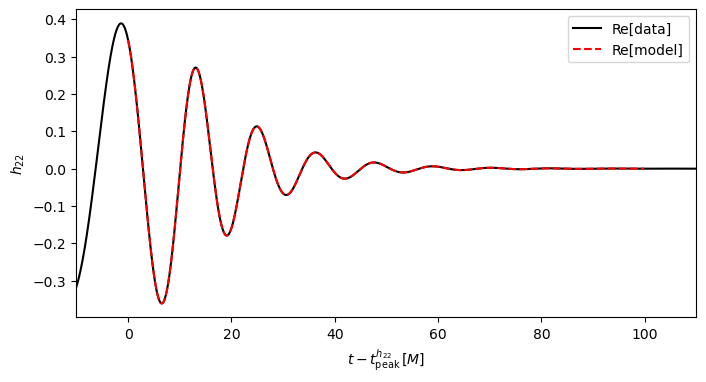

In [10]:
# Plot the best-fit model against the data

h_best_fit = best_fit['model']
h22_best_fit = h_best_fit.data[:, h_best_fit.index(2,2)]

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(h.t, np.real(h22), c='k', label='Re[data]')
ax.plot(
    h_best_fit.t, 
    np.real(h22_best_fit), 
    c='r', 
    ls='--',
    label='Re[model]'
)

ax.set_xlabel('$t - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$h_{22}$')

ax.legend()

ax.set_xlim(-10, 110);

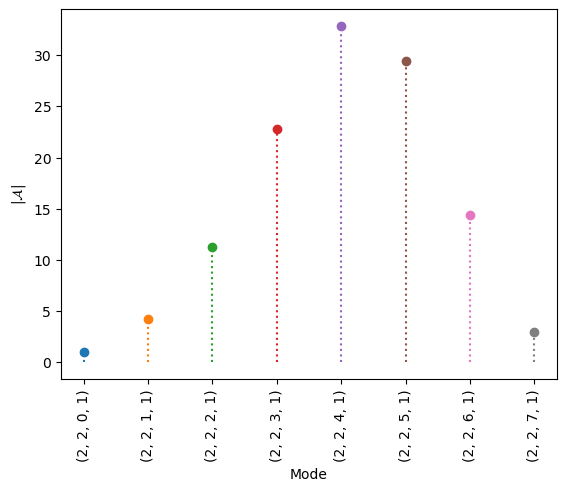

In [11]:
# Plot the best-fit mode amplitudes

amplitudes = [abs(best_fit['amplitudes'][label]) for label in qnms]
labels = [str(label) for label in qnms]

# x-axis values, useful for plotting
x = np.arange(len(amplitudes))
    
fig, ax = plt.subplots()

for i in range(len(amplitudes)):
    ax.plot(
        [x[i],x[i]], [0,amplitudes[i]], color=f'C{i}', marker='o', 
        markevery=(1,2), linestyle=':')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', rotation=90)

ax.set_xlabel('Mode')
ax.set_ylabel('$|\mathcal{A}|$');

In [12]:
best_fit['mismatch']

3.041426970273875e-07

## Perform fits for a range of ringdown start times

We can create the common mismatch curves in the following way:

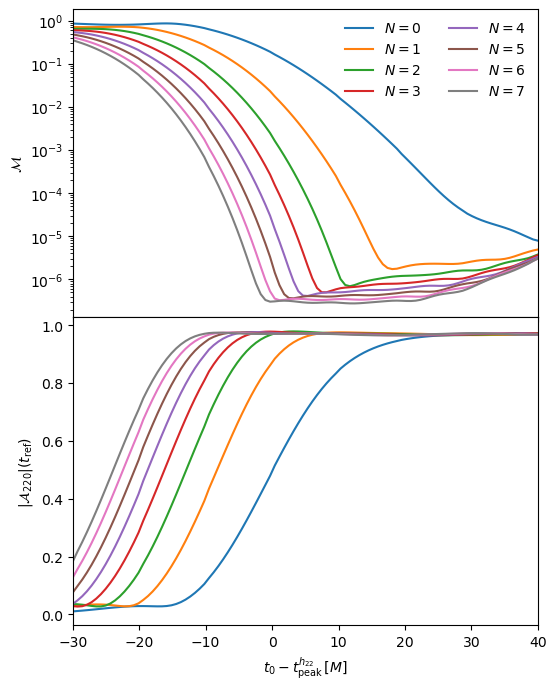

In [13]:
# Now perform fits with different numbers of overtones, from N=0 to N=7
qnm_list = [[(2,2,n,1) for n in range(N)] for N in range(1,7+2)]
spherical_modes = [(2,2)]

# The start times to use
t0_array = np.linspace(-30, 40, 100)

# We can specify a reference time for when the QNM amplitudes are defined. This
# is useful for investigating mode stability.
t_ref = 0

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(6,8), sharex=True)
fig.subplots_adjust(hspace=0)

# We will store the fundamental mode amplitudes for each fit to investigate
# mode stability
A220_dict = {}

for N, qnms in enumerate(qnm_list):

    # Store the fundamental mode amplitude for each start time, and the 
    # mismatch
    A220_dict[N] = []
    mm_list = []

    for t0 in t0_array:
        best_fit = qnmfits.fit(
            data=h,
            chif=chif_mag,
            Mf=Mf,
            qnms=qnms,
            spherical_modes=spherical_modes,
            t0=t0,
            t_ref=t_ref
        )
        mm_list.append(best_fit['mismatch'])
        A220_dict[N].append(abs(best_fit['amplitudes'][2,2,0,1]))
        
    # Add to figure
    axs[0].semilogy(t0_array, mm_list, label=f'$N = {N}$')
    axs[1].plot(t0_array, A220_dict[N])
    
# Plot limits and labels
axs[0].set_xlim(t0_array[0], t0_array[-1])
axs[1].set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\, [M]$')
axs[0].set_ylabel('$\mathcal{M}$')
axs[1].set_ylabel('$|\mathcal{A}_{220}|(t_\mathrm{ref})$')

axs[0].legend(ncol=2, frameon=False);

## Multimode fits

In [14]:
qnms = [(ell,2,n,1) for ell in range(2,3+1) for n in range(7+1)]

# Simply include the additional spherical modes in the list, and the code takes
# care of the mode mixing
spherical_modes = [(2,2),(3,2)]

t0 = 0

best_fit = qnmfits.fit(
    data=h,
    chif=chif_mag, 
    Mf=Mf,
    qnms=qnms,
    spherical_modes=spherical_modes,
    t0=t0
)

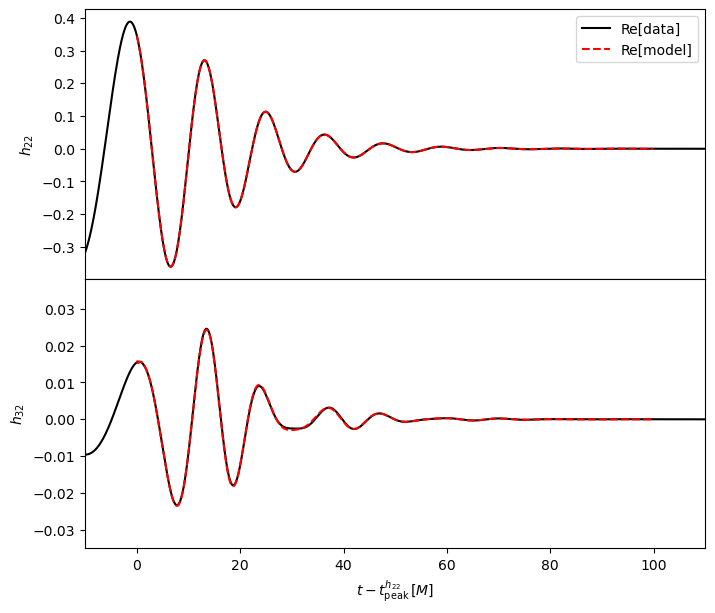

In [15]:
# Plot the best-fit model against the data

h32 = h.data[:,h.index(3,2)]

h_best_fit = best_fit['model']
h22_best_fit = h_best_fit.data[:, h_best_fit.index(2,2)]
h32_best_fit = h_best_fit.data[:, h_best_fit.index(3,2)]

fig, axs = plt.subplots(2, figsize=(8,7), sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(h.t, np.real(h22), c='k', label='Re[data]')
axs[0].plot(
    h_best_fit.t, 
    np.real(h22_best_fit), 
    c='r', 
    ls='--',
    label='Re[model]'
)

axs[1].plot(h.t, np.real(h32), c='k')
axs[1].plot(
    h_best_fit.t, 
    np.real(h32_best_fit), 
    c='r', 
    ls='--',
)

axs[1].set_xlabel('$t - t_\mathrm{peak}^{h_{22}}\, [M]$')
axs[0].set_ylabel('$h_{22}$')
axs[1].set_ylabel('$h_{32}$')

axs[0].legend()

axs[0].set_xlim(-10, 110);

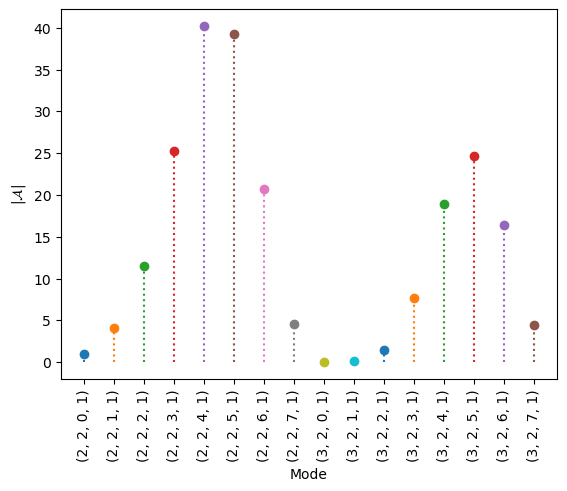

In [16]:
# Plot the best-fit mode amplitudes

amplitudes = [abs(best_fit['amplitudes'][label]) for label in qnms]
labels = [str(label) for label in qnms]

# x-axis values, useful for plotting
x = np.arange(len(amplitudes))
    
fig, ax = plt.subplots()

for i in range(len(amplitudes)):
    ax.plot(
        [x[i],x[i]], [0,amplitudes[i]], color=f'C{i}', marker='o', 
        markevery=(1,2), linestyle=':')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', rotation=90)

ax.set_xlabel('Mode')
ax.set_ylabel('$|\mathcal{A}|$');

In [17]:
best_fit['mismatch']

1.2786140248799427e-06